# 2021 2학기 HCI - 표정 인식 실습 패키지
# 03. 표정 인식

### #1. 모듈 선언 

In [11]:
from libs.Face import FacialLandmarkDetector
from libs.FacialExpression import DataAnalyzer
import libs.Face as Face
import cv2


# 얼굴 특징점 검출 모듈 선언
facial_landmark_detector = FacialLandmarkDetector(
        model=Face.FACIAL_LANDMARK_DETECTION_MODEL_MEDIAPIPE,
        face_detector=Face.FACE_DETECTION_MODEL_OPENCV_DNN)

# 데이터 분석 모듈 선언
data_analyzer = DataAnalyzer()

### #2. 데이터 추출하기

SUCCESS :: 데이터 생성이 완료되었습니다. name=neutral
SUCCESS :: 데이터 생성이 완료되었습니다. name=happiness


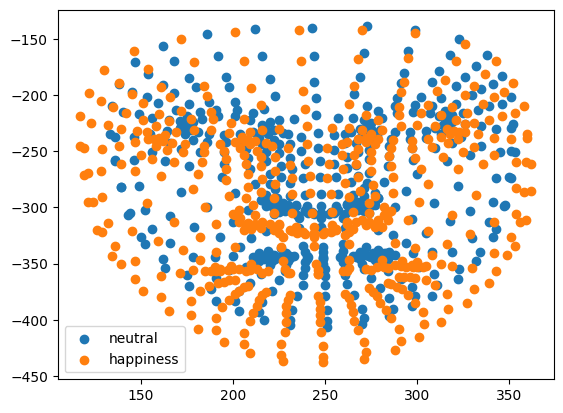

In [12]:
import matplotlib.pyplot as plt

# 경로 상의 이미지를 읽어오기
img_neutral = cv2.imread("./datasets/neutral/appletree_open_neutral_01_210719.jpg")
img_happiness = cv2.imread("./datasets/happiness/appletree_open_happiness_01_210719.jpg")

# 추출한 데이터를 따로 저장하기 위한 name 변수 리스트
name_list = ["neutral", "happiness"]

# 이미지 사이즈를 조정 가로 480, 세로 640
img_neutral = cv2.resize(img_neutral, (480, 640))
img_happiness = cv2.resize(img_happiness, (480, 640))

for idx, img in enumerate([img_neutral, img_happiness]):
    # feed(img): 이미지(BGR 형식)를 입력받아 얼굴 검출 및 얼굴 특징점을 검출한다.
    facial_landmark_detector.feed(img)

    # getIsDetect(): 얼굴 검출 여부를 확인하는 함수. 얼굴이 검출되면 True를, 아니면 False를 반환함.
    if facial_landmark_detector.getIsDetect():

        # getFacialLandmark(): 검출된 얼굴 특징점을 반환하는 함수. 얼굴 영역은 FacialLandmark 객체로 반환된다.
        landmarks = facial_landmark_detector.getFacialLandmark()

        # FacialLandmark(x. y) 객체 : x, y 2가지 배열로 이루어져 있다.
        # x : 얼굴 특징점의 x 좌표 리스트
        # y : 얼굴 특징점의 y 좌표 리스트
        # 각각의 리스트는 getX(). getY() 함수로 반환받을 수 있다.
        x = landmarks.getX()
        y = landmarks.getY()

        data_analyzer.appendData(name=name_list[idx], value=[x, -y])

# 플로팅 결과 출력
data_analyzer.plotDatas(names=name_list, type='scatter')

### #3 데이터 정규화하기
이미지의 해상도 및 이미지 내의 얼굴의 위치, 차지하는 크기 등에 따라 정확한 비교가 어려워짐. 이를 해결하기 위해 정규화(Normalization)를 진행하여 비율적인 값으로 스케일링(Scaling)을 진행

In [13]:
from libs.FacialExpression import DataAnalyzer
import numpy as np

def min_max_normalization(value):
    value = list(value)
    
    _max = max(value)
    _min = min(value)
    
    result = []
    
    for val in value:
        _val = (val - _min) / (_max - _min)
        result.append(_val)
        
    return np.array(result)

가장 보편적인 최대-최소 정규화(min-max normalization)를 진행한 후 결과를 확인

SUCCESS :: 데이터 생성이 완료되었습니다. name=normalized neutral
SUCCESS :: 데이터 생성이 완료되었습니다. name=normalized happiness


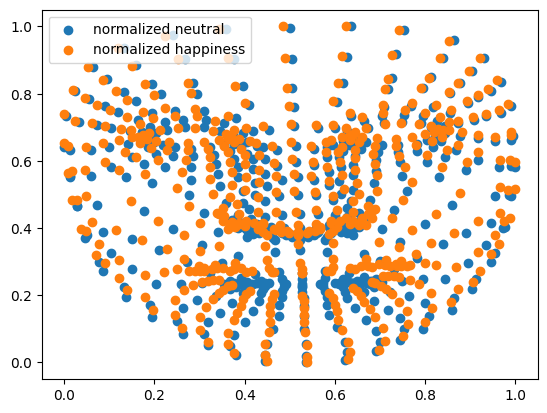

In [14]:
# Data Analyzer에 입력된 데이터를 다시 불러오기
landmark_neutral = data_analyzer.getData(name='neutral')
landmark_happiness = data_analyzer.getData(name='happiness')

# Neutral 이미지에서 추출한 landmark를 정규화 
normalized_landmark_neutral_x = min_max_normalization(landmark_neutral[0])
normalized_landmark_neutral_y = min_max_normalization(landmark_neutral[1])

# Happiness 이미지에서 추출한 landmark를 정규화
normalized_landmark_happiness_x = min_max_normalization(landmark_happiness[0])
normalized_landmark_happiness_y = min_max_normalization(landmark_happiness[1])

# 정규화된 얼굴 특징점 플로팅
data_analyzer.appendData(name='normalized neutral', value=[normalized_landmark_neutral_x, normalized_landmark_neutral_y])
data_analyzer.appendData(name='normalized happiness', value=[normalized_landmark_happiness_x, normalized_landmark_happiness_y])

data_analyzer.plotDatas(names=['normalized neutral', 'normalized happiness'])

### #4 기계 학습

기계 학습(Machine Learning) 모델은 데이터의 특징만을 학습한다. 즉 학습 데이터 수가 많을 수록, 추출된 특징이 두 그룹의 차이를 명확히 드러낼 수록 좋은 성능의 모델을 학습시킬 수 있다.

In [2]:
from libs.FacialExpression import FacialExpressionRecognizer

import numpy as np

# 기계학습 모델 선언
facial_expression_recognizer = FacialExpressionRecognizer(kernel='linear', C=1)

# 모델 학습 진행
# data: 학습시킬 input 데이터 배열. list 형태로 입력해주어야 하며, 리스트의 크기는 '데이터 수 x 특징 수' 로 2차원 배열이 되어야함.
# ex. 데이터 수 9장, feature 수 5개일 경우 input의 형태는 다음과 같음.(특징값은 임의로 설정함)
# [[1,2,3,4,5], [1,2,3,4,5], [1,2,3,4,5],
#  [1,2,3,4,5], [1,2,3,4,5], [1,2,3,4,5],
#  [1,2,3,4,5], [1,2,3,4,5], [1,2,3,4,5]]
# label: 학습시킬 input 데이터의 label 배열. list 형태로 입력해주어야 하며, 각 label 값의 위치는 해당 input의 위치와 동일해야함.
# ex. 데이터 수 9장, 3가지 분류 데이터일 경우
# [[0], [0], [0],
#  [1], [1], [1],
#  [2], [2], [2]]
# 훈련용 데이터셋 랜덤 생성
train_1 = np.random.randint(0, 30, (50, 2))
label_1 = np.zeros((50, 1))
train_2 = np.random.randint(40, 70, (50, 2))
label_2 = np.ones((50, 1))
train_X = np.concatenate((train_1, train_2), axis=0)
train_Y = np.concatenate((label_1, label_2), axis=0)
train_Y = train_Y.ravel()  # train_Y를 1D 배열로 변환

# 모델 학습 진
facial_expression_recognizer.train(data=train_X, label=train_Y)

test(data, label) 함수를 통해 테스트 데이터셋을 이용하여 학습된 모델을 테스트 해볼 수 있다. 테스트 결과로 정확도(Accuracy)를 반환한다.

In [3]:
test_X, test_Y = train_X, train_Y

# 모델 평가
# data: 학습시킬 input 데이터 배열
# label: 학습시킬 input 데이터의 label 배열
facial_expression_recognizer.test(data=test_X, label=test_Y)

Accuracy: 1.0


feed(test_data) 함수를 통해 학습된 모델을 단일 입력으로 예측 해볼수 있다.

In [4]:
test_data = [[20, 20]]

# 모델 예측
# data: 예측을 시도할 입력 데이터
# result: 예측 결과 (label)
facial_expression_recognizer.feed(data=test_data)
result = facial_expression_recognizer.getPrediction()

print(result)

[0.]


draw_SVM 함수를 통해 학습된 모델의 결과를 시각화 할 수 있다. (2개 분류군에 대해서만 가능)

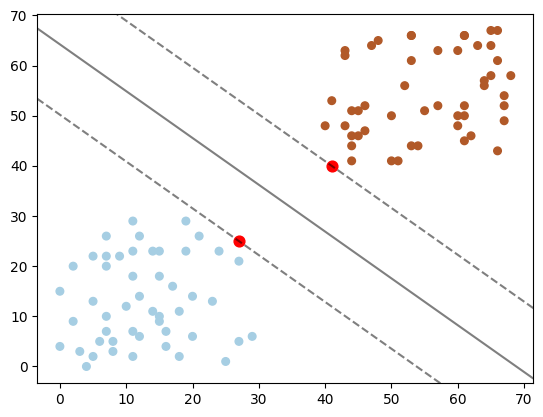

In [5]:
facial_expression_recognizer.draw_SVM(X=train_X, Y=train_Y)

 .save() 함수를 이용하여 학습 시킨 모델을 저장할 수 있다.

In [6]:
facial_expression_recognizer.save(filename="SVM_Test_C=1") # 확장자 명은 자동으로 붙여준다.

저장된 모델은 .load() 함수를 이용하여 불러온다.

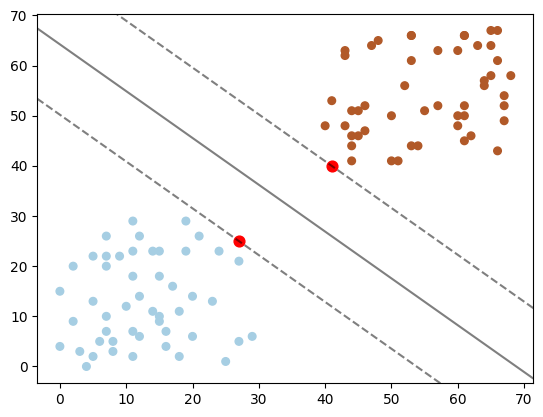

In [7]:
new_model = FacialExpressionRecognizer()

new_model.load("SVM_Test_C=1.pkl") # 확장자 명까지 붙여줄 것

new_model.draw_SVM(X=train_X, Y=train_Y)

불러온 모델 역시 같은 결과가 나오는 것을 확인 할 수 있다.